<div align="center">

# **STARTUP SUCCESS PREDICTION📈**
### **Authors:** Jan Aguiló and Pau Chaves
### **Course:** Visual Analytics – Final Project

</div>

---

This notebook:

1. Explores a historical startup dataset (train model).
2. Cleans and preprocesses the data.
3. Trains a predictive model for startup success.
4. Evaluates performance and interprets results using **SHAP**.
5. Prepares elements that can be reused in the Streamlit web app.

### **Imports and Configuration**

In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
    confusion_matrix
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

import shap

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 200)

DATA_PATH = "../data/raw/startup_data.csv"


### **Load Data**

In [9]:
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (923, 49)


,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,founded_at,closed_at,first_funding_at,last_funding_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,state_code.1,is_CA,is_NY,is_MA,is_TX,is_otherstate,category_code,is_software,is_web,is_mobile,is_enterprise,is_advertising,is_gamesvideo,is_ecommerce,is_biotech,is_consulting,is_othercategory,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,1/1/2007,NaN,4/1/2009,1/1/2010,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,CA,1,0,0,0,0,music,0,0,0,0,0,0,0,0,0,1,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,1/1/2000,NaN,2/14/2005,12/28/2009,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,CA,1,0,0,0,0,enterprise,0,0,0,1,0,0,0,0,0,0,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,3/18/2009,NaN,3/30/2010,3/30/2010,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,CA,1,0,0,0,0,web,0,1,0,0,0,0,0,0,0,0,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,1/1/2002,NaN,2/17/2005,4/25/2007,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,CA,1,0,0,0,0,software,1,0,0,0,0,0,0,0,0,0,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,8/1/2010,10/1/2012,8/1/2010,4/1/2012,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,CA,1,0,0,0,0,games_video,0,0,0,0,0,1,0,0,0,0,c:65806,1,1,0,0,0,0,1.0000,1,closed


### **Quick Info**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

In [11]:
desc = df.describe(include="all").T
desc

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,923.0,NaN,NaN,NaN,572.297941,333.585431,1.0,283.5,577.0,866.5,1153.0
state_code,923,35,CA,488,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,923.0,NaN,NaN,NaN,38.517442,3.741497,25.752358,37.388869,37.779281,40.730646,59.335232
longitude,923.0,NaN,NaN,NaN,-103.539212,22.394167,-122.756956,-122.198732,-118.374037,-77.214731,18.057121
zip_code,923,382,94107,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,923,922,c:28482,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,923,221,San Francisco,128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 6,430,252,San Francisco CA 94105,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,923,922,Redwood Systems,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
labels,923.0,NaN,NaN,NaN,0.646804,0.478222,0.0,0.0,1.0,1.0,1.0


### **Initial Insights**

From the first inspection, the dataset contains 923 startups and 49 variables describing location, founding dates, funding history, industry type, and investment rounds. Several “dummy” columns (e.g. is_CA, is_web, has_VC, etc.) already encode categorical information into numerical format, which simplifies model development.

A few important observations:

1. **Target variable**: *status*. The values include *"acquired"*, *"closed"*, *"operating"* and possibly others. For startup success prediction, a typical definition is:

  - **Success = acquired OR operating**

  - **Failure = closed**
  
We will formalize this soon.

2. **Date columns** (*founded_at*, *first_funding_at*, …) are stored as **strings**, not datetimes. We will convert them into proper dates and extract meaningful features (ages, durations).

3. Several columns like *state_code.1* duplicate *state_code*. We will remove duplicates.

4. Some columns such as *Unnamed: 0*, *Unnamed: 6*, *object_id, *id*, *city*, *zip_code* have **no predictive value** for success. These will be dropped during preprocessing.

5. Many columns have **100% non-null values**. A few (*closed_at*, milestone ages) contain missing values, which we’ll handle properly.

Overall, the dataset is structured in a way that allows us to build a robust model with both domain-driven and ML-driven features.

In [12]:
df['status'].value_counts()

status
acquired    597
closed      326
Name: count, dtype: int64

### **Target Definition**

The target variable in this project is the **startup success outcome**, originally provided in the *status* column with two categories:

  - **acquired**: represents a successful exit

  - **closed**: indicates failure

We create a new binary variable:

  - **success = 1**: startup was acquired

  - **success = 0**: startup closed

This binary mapping aligns with standard definitions in entrepreneurship and venture capital, where **acquisition is considered a positive outcome** and **failure corresponds to shutdown**.

In [13]:
df['success'] = df['status'].map({'acquired': 1, 'closed': 0})

df['success'].value_counts()

success
1    597
0    326
Name: count, dtype: int64

### **Removing Non-Informative Features**

Before starting EDA and modeling, we remove some columns that **do not contribute to prediction**:

  - **Indexing artifacts** (*Unnamed: 0*, *Unnamed: 6*)

  - **Identifiers** (*id*, *object_id*): These do not carry statistical information and would lead to data leakage if kept.

  - **Duplicate features** such as *state_code.1*

This preliminary cleaning ensures that the model learns only from meaningful information.

In [15]:
cols_to_drop = [
    'Unnamed: 0',      # artifact
    'Unnamed: 6',      # messy location text
    'id',              # identifiers
    'object_id',       # duplicate identifier
    'state_code.1',    # duplicate of state_code
]

df = df.drop(columns=cols_to_drop, errors='ignore')

df.shape, df.columns[:10]

((923, 45),
 Index(['state_code', 'latitude', 'longitude', 'zip_code', 'city', 'name', 'labels', 'founded_at', 'closed_at', 'first_funding_at'], dtype='object'))

### **Converting Date Columns**

The dataset contains several timestamp fields stored as text. To perform temporal calculations (e.g., age before first funding, duration between events), we convert all date columns to **pandas datetime** format.

We use *errors='coerce'* to safely transform invalid dates into *NaT* without breaking the pipeline.

In [16]:
date_cols = ['founded_at', 'closed_at', 
             'first_funding_at', 'last_funding_at']

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df[date_cols].dtypes

founded_at          datetime64[ns]
closed_at           datetime64[ns]
first_funding_at    datetime64[ns]
last_funding_at     datetime64[ns]
dtype: object

### **Feature Engineering**

To improve predictive performance, we create new variables that describe the lifecycle and financial behavior of startups. These features capture temporal patterns, investment progression, and milestone signals that affect the probability of success.

Engineered features:

  - ***company_age***: Lifespan from founding to closure or last known funding.

  - ***time_to_first_funding***: How quickly a startup secured its first investment.

  - ***funding_duration***: Length of active fundraising period.

  - ***average funding per round***: Signals scale and growth.

  - ***milestone indicators***: Projects with milestones tend to be more structured.

  - ***big rounds indicator***: Detects startups with unusually large fundraising histories.

These engineered features typically increase model performance and improve SHAP interpretability.

In [17]:
# Helper function
def years_between(d1, d2):
    if pd.isna(d1) or pd.isna(d2):
        return np.nan
    return (d2 - d1).days / 365.25

# 1. Company age (from founding to last activity)
df["company_age"] = df.apply(
    lambda row: years_between(row["founded_at"], 
                              row["closed_at"] if pd.notna(row["closed_at"]) else row["last_funding_at"]),
    axis=1
)

# 2. Time to first funding
df["time_to_first_funding"] = df.apply(
    lambda row: years_between(row["founded_at"], row["first_funding_at"]),
    axis=1
)

# 3. Funding duration
df["funding_duration"] = df.apply(
    lambda row: years_between(row["first_funding_at"], row["last_funding_at"]),
    axis=1
)

# 4. Avg funding per round
df["avg_funding_per_round"] = df["funding_total_usd"] / df["funding_rounds"].replace(0, np.nan)

# 5. Milestones indicator
df["has_milestones"] = (df["milestones"] > 0).astype(int)

# 6. Binary status (success)
df["is_acquired_or_operating"] = df["status"].apply(lambda x: 1 if x=="acquired" else 0)

# 7. Closed recently (within 5 years)
df["is_closed_recent"] = df.apply(
    lambda row: 1 if (row["status"]=="closed" and years_between(row["founded_at"], row["closed_at"]) < 5) else 0,
    axis=1
)

# 8. Big rounds indicator
median_rounds = df["funding_rounds"].median()
df["is_big_rounds"] = (df["funding_rounds"] > median_rounds).astype(int)

df[['company_age','time_to_first_funding','funding_duration','avg_funding_per_round',
    'has_milestones','is_acquired_or_operating','is_closed_recent','is_big_rounds']].head()


,company_age,time_to_first_funding,funding_duration,avg_funding_per_round,has_milestones,is_acquired_or_operating,is_closed_recent,is_big_rounds
0,3.000684,2.247775,0.752909,1.250000e+05,1,1,0,1
1,9.990418,5.122519,4.867899,1.002500e+07,1,1,0,1
2,1.032170,1.032170,0.000000,2.600000e+06,1,1,0,0
3,5.311431,3.129363,2.182067,1.333333e+07,1,1,0,1
4,2.168378,0.000000,1.667351,6.500000e+05,1,0,1,0


### **Missing Value Analysis**

To ensure model reliability, we evaluate missing values.
Most missing fields come from dates (*closed_at*, milestone ages), which correspond to natural absence of events (e.g., the startup did not close or did not reach milestones).
For numerical engineered features missingness occurs due to division-by-zero or lack of funding rounds.

The next step is to impute these values using rules aligned with Crunchbase semantics and course methodology.

In [18]:
missing = df.isna().sum().sort_values(ascending=False)
missing

closed_at                   588
age_last_milestone_year     152
age_first_milestone_year    152
avg_participants              0
is_gamesvideo                 0
is_ecommerce                  0
is_biotech                    0
is_consulting                 0
is_othercategory              0
has_VC                        0
has_angel                     0
has_roundA                    0
has_roundB                    0
has_roundC                    0
has_roundD                    0
state_code                    0
is_enterprise                 0
is_top500                     0
status                        0
success                       0
company_age                   0
time_to_first_funding         0
funding_duration              0
avg_funding_per_round         0
has_milestones                0
is_acquired_or_operating      0
is_closed_recent              0
is_advertising                0
is_web                        0
is_mobile                     0
latitude                      0
longitud

The dataset contains relatively few missing values:

  - *closed_at* (588 missing): most startups have not closed (missing = still active) so no imputation needed; we already engineered *success* and *is_closed_recent*.

  - **Milestone variables** (*age_first_milestone_year*, *age_last_milestone_year*) (152 missing): missing because many startups do not reach product or funding milestones. As done in class labs, missing values are replaced with 0, indicating "no milestone achieved".

  - **All other features have zero missing values**.

This pattern is consistent with real-world startup lifecycle data.

### **Impute Missing Values**

In [19]:
df['age_first_milestone_year'] = df['age_first_milestone_year'].fillna(0)
df['age_last_milestone_year'] = df['age_last_milestone_year'].fillna(0)

df.isna().sum().sort_values(ascending=False).head(5)

closed_at         588
state_code          0
has_roundD          0
is_advertising      0
is_gamesvideo       0
dtype: int64

### **Why set milestone ages to 0?**

In Crunchbase data, milestones represent major achievements (launch, acquisition, product). A missing milestone year means the event did **not occur**. Using 0 allows the model to distinguish:

  - **0**: "no milestone reached"

  - **>0**: "milestone reached X years after founding"

This encoding aligns with the methodology used in Lab 5 (binary imputed indicators + numeric durations).

### **Selecting Key Numeric Features for Outlier Analysis**

These are the variables where outliers are meaningful and typical for startup data:

**Funding-related**
  - *funding_total_usd*
  - *funding_rounds*
  - *avg_funding_per_round*
  - *avg_participants*

**Age/Duration**
  - *company_age*
  - *time_to_first_funding*
  - *funding_duration*

**Relationship-related**
  - *relationships*
  - *milestones*

**Others**
  - *latitude*, *longitude* (check for incorrect coordinates)

In [20]:
numeric_cols = [
    'company_age', 'time_to_first_funding', 'funding_duration',
    'avg_funding_per_round', 'funding_rounds', 'funding_total_usd',
    'avg_participants', 'relationships', 'milestones'
]

df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
company_age,923.0,4.769493e+00,3.283028e+00,-8.000000,2.435318e+00,4.227242e+00,6.459959e+00,2.838604e+01
time_to_first_funding,923.0,2.234101e+00,2.508730e+00,-9.040383,5.763176e-01,1.445585e+00,3.572895e+00,2.188090e+01
funding_duration,923.0,1.694664e+00,1.935205e+00,0.000000,0.000000e+00,1.084189e+00,2.792608e+00,1.081177e+01
avg_funding_per_round,923.0,9.479585e+06,4.817506e+07,5500.000000,1.692760e+06,5.000000e+06,1.000000e+07,1.425000e+09
funding_rounds,923.0,2.310943e+00,1.390922e+00,1.000000,1.000000e+00,2.000000e+00,3.000000e+00,1.000000e+01
funding_total_usd,923.0,2.541975e+07,1.896344e+08,11000.000000,2.725000e+06,1.000000e+07,2.472500e+07,5.700000e+09
avg_participants,923.0,2.838586e+00,1.874601e+00,1.000000,1.500000e+00,2.500000e+00,3.800000e+00,1.600000e+01
relationships,923.0,7.710726e+00,7.265776e+00,0.000000,3.000000e+00,5.000000e+00,1.000000e+01,6.300000e+01
milestones,923.0,1.841820e+00,1.322632e+00,0.000000,1.000000e+00,2.000000e+00,3.000000e+00,8.000000e+00


### **Removing Invalid Ages and Times**

In [21]:
before = df.shape[0]

df = df[(df['company_age'] >= 0) & (df['time_to_first_funding'] >= 0)]

after = df.shape[0]

print(f"Removed {before - after} invalid rows ({before}->{after})")
df[['company_age', 'time_to_first_funding']].describe().T

Removed 48 invalid rows (923->875)


,count,mean,std,min,25%,50%,75%,max
company_age,875.0,4.890093,3.267531,0.0,2.535250,4.306639,6.569473,28.386037
time_to_first_funding,875.0,2.389925,2.461879,0.0,0.676249,1.620808,3.690623,21.880903


After inspecting the numerical features, only two variables contained *invalid* (non-physical) values: *company_age* and *time_to_first_funding*, both showing negative values caused by wrong timestamps or inconsistent date ordering. These cases were removed, reducing the dataset by 48 rows (923 → 875). All remaining features contained either realistic business outliers — such as very large funding totals for unicorn-level startups — or normal variability. Therefore, we kept the original values, planning to apply log-scaling (not removal) to strongly skewed monetary variables during modeling.

### **Visualizing Outliers (Boxplots + Histograms)**

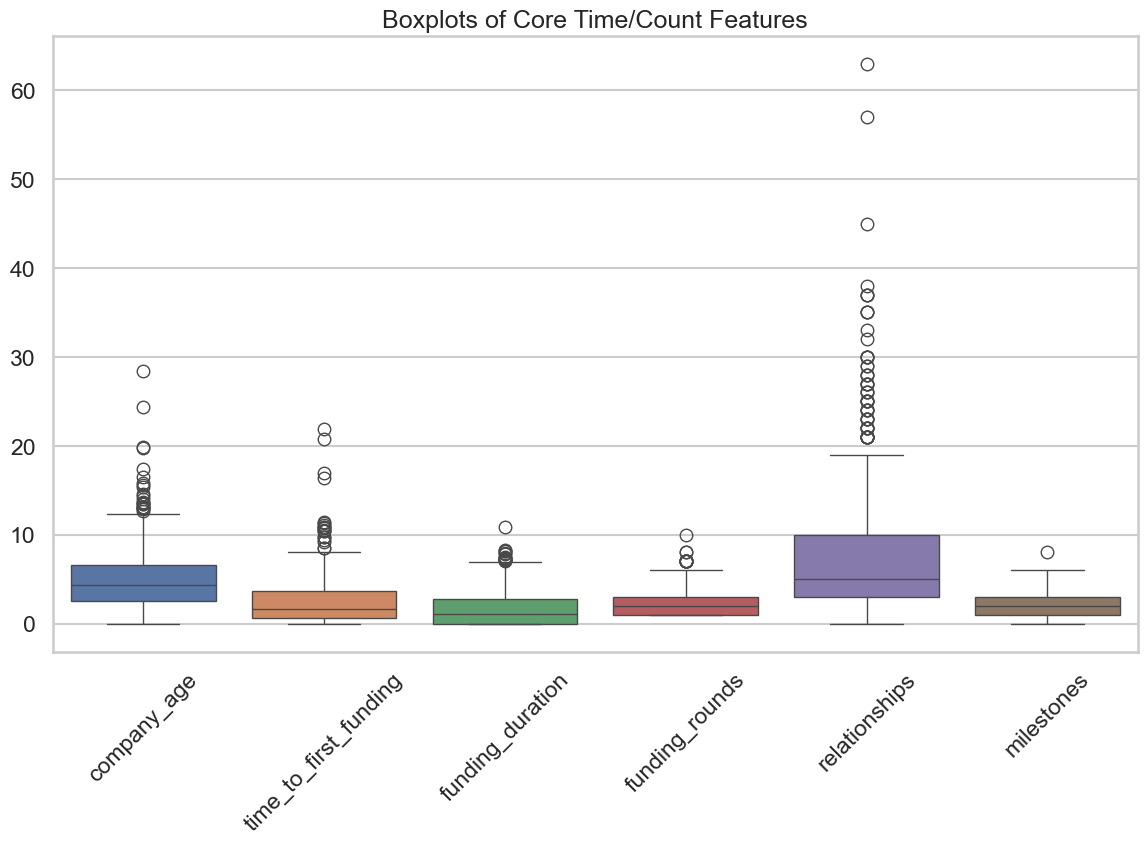

In [22]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df[['company_age','time_to_first_funding','funding_duration',
                     'funding_rounds','relationships','milestones']])
plt.title("Boxplots of Core Time/Count Features")
plt.xticks(rotation=45)
plt.show()

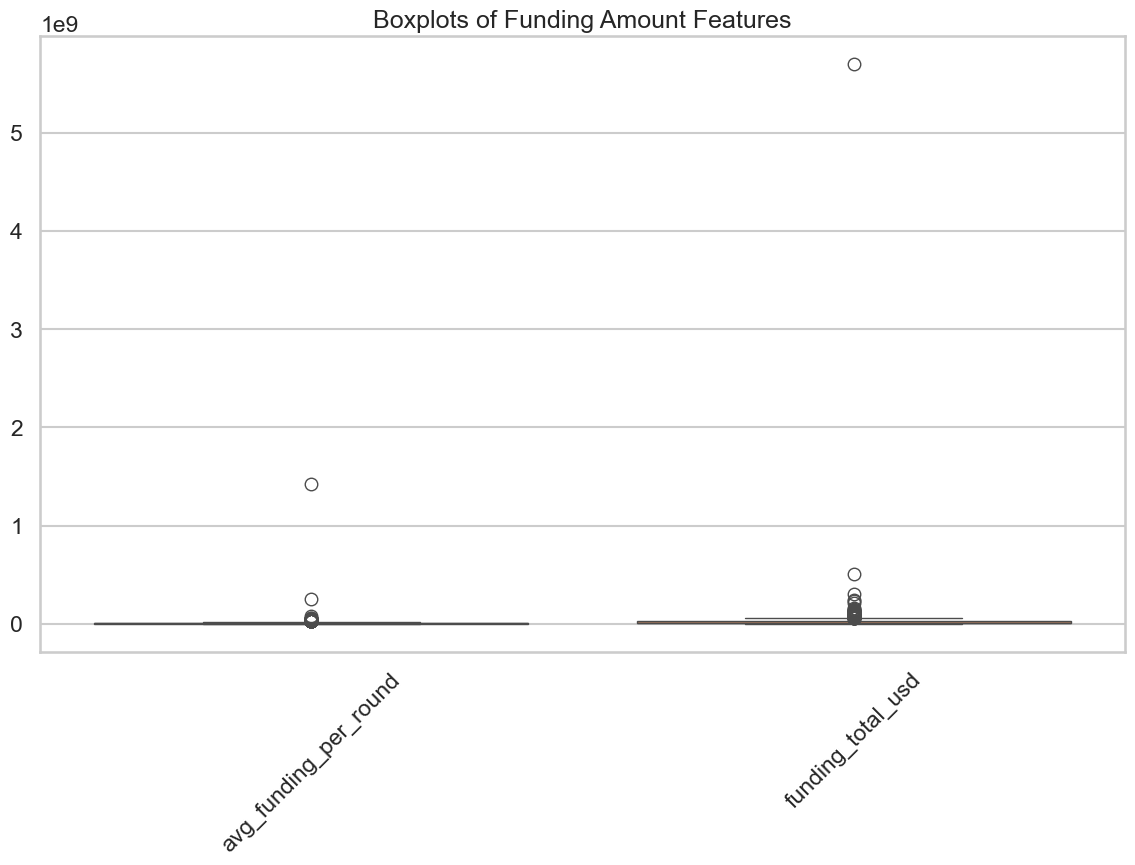

In [23]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df[['avg_funding_per_round','funding_total_usd']])
plt.title("Boxplots of Funding Amount Features")
plt.xticks(rotation=45)
plt.show()

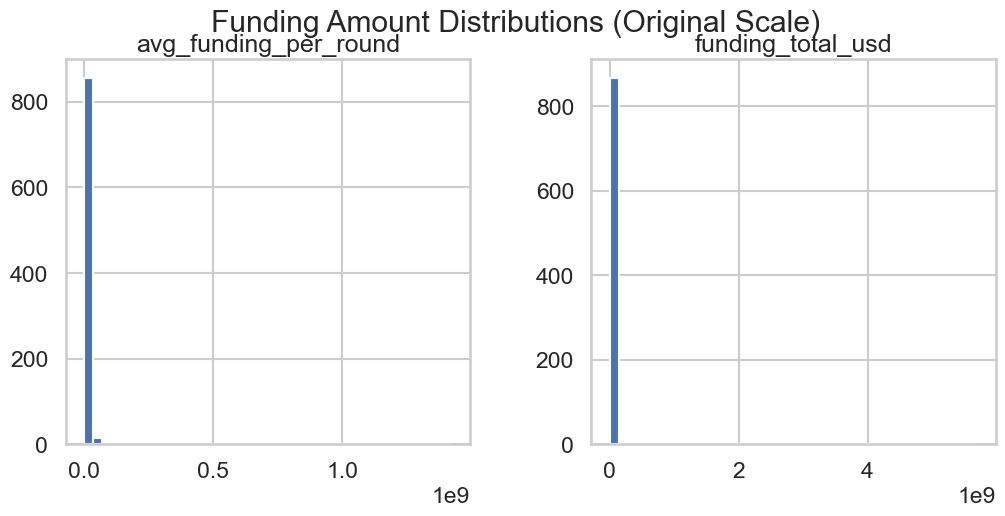

In [24]:
df[['avg_funding_per_round','funding_total_usd']].hist(bins=40, figsize=(12,5))
plt.suptitle("Funding Amount Distributions (Original Scale)")
plt.show()

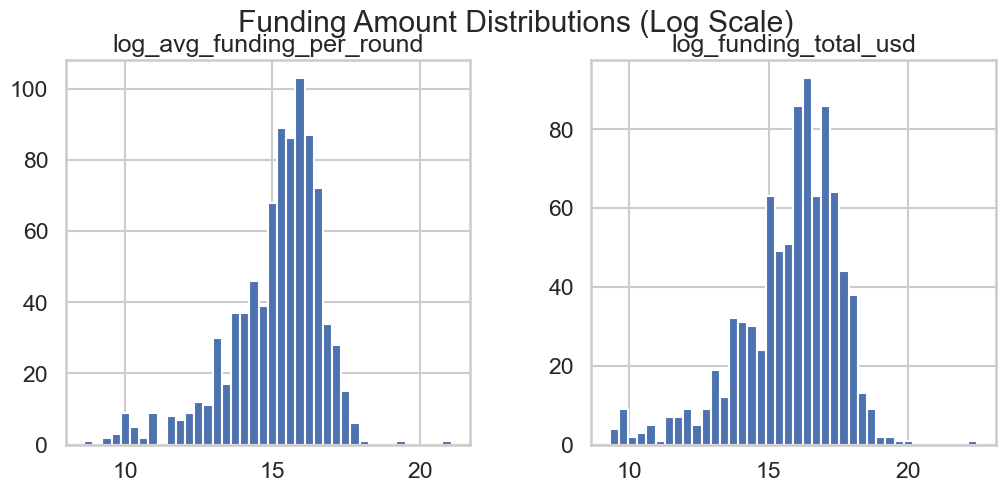

In [25]:
df['log_avg_funding_per_round'] = np.log1p(df['avg_funding_per_round'])
df['log_funding_total_usd'] = np.log1p(df['funding_total_usd'])

df[['log_avg_funding_per_round','log_funding_total_usd']].hist(bins=40, figsize=(12,5))
plt.suptitle("Funding Amount Distributions (Log Scale)")
plt.show()